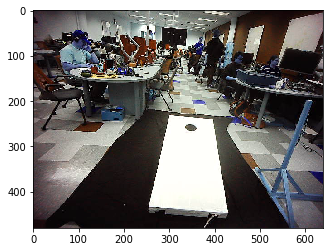

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
%matplotlib inline

# Load original source
img = cv.imread('testpics/tbg0.png')
orig = img.copy()
plt.imshow(img)

# Utility functions for dealing with contours
def get_cnt_details(cnt):
    M = cv.moments(cnt)
    details = None
    
    # if the moment is at point 00
    if (M['m00'] != 0):
        details = {}
        details['cx'] = cx = int(M['m10']/M['m00'])
        details['cy'] = cy = int(M['m01']/M['m00'])
        details['area'] = area = cv.contourArea(cnt)
        details['perimeter'] = perimeter = cv.arcLength(cnt,True)
        
        approx = cv.approxPolyDP(cnt,0.01*cv.arcLength(cnt,True),True)
        details['num_vertices'] = len(approx)
    else:
        return None

    if (details['area'] < 16):
        return None
    else:
        return details

def print_cnt_details(cnt):
    cnt_dict = get_cnt_details(cnt)
    
    if (cnt_dict is None):
        return
    
    cx = cnt_dict['cx']
    cy = cnt_dict['cy']
    area = cnt_dict['area']
    perimeter = cnt_dict['perimeter']
    num_vertices = cnt_dict['num_vertices']
    
    print('cx: ', cx, '\tcy: ', cy, '\tarea: ', area, '\tperimeter: ', perimeter, '\tvertices: ', num_vertices)

def cnt_is_circular(cnt):
    cnt_det = get_cnt_details(cnt)
    if (cnt_det is None):
        return False
    area = cnt_det['area']
    perimeter = cnt_det['perimeter']
    num_vertices = cnt_det['num_vertices']
    return True if (num_vertices < 15 and num_vertices > 4) else False

def cnt_is_board(cnt):
    cnt_det = get_cnt_details(cnt)
    if (cnt_det is None):
        return False
    area = cnt_det['area']
    num_vertices = cnt_det['num_vertices']
    approx = cv.approxPolyDP(cnt,0.01*cv.arcLength(cnt,True),True)
    return True if (area > 20000 and num_vertices == 4) else False


In [2]:
# Crop the image so we only observe the bottom half when finding contours
height, width, channels = img.shape
print('original_img\nheight: ', height, '\twidth: ', width, '\tchannels: ', channels)
# crop = img[0:width, 200:height]

original_img
height:  480 	width:  640 	channels:  3


cx:  389 	cy:  462 	area:  35.5 	perimeter:  61.012192606925964 	vertices:  14
cx:  345 	cy:  347 	area:  27398.5 	perimeter:  727.3208485841751 	vertices:  4
cx:  347 	cy:  258 	area:  312.5 	perimeter:  69.35533845424652 	vertices:  12
cx:  346 	cy:  222 	area:  183.5 	perimeter:  129.8406196832657 	vertices:  21


Text(0.5, 1.0, 'Cropped With Board/Circle Contours')

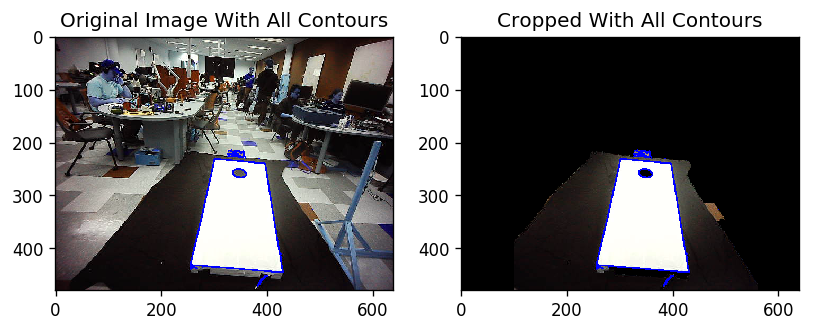

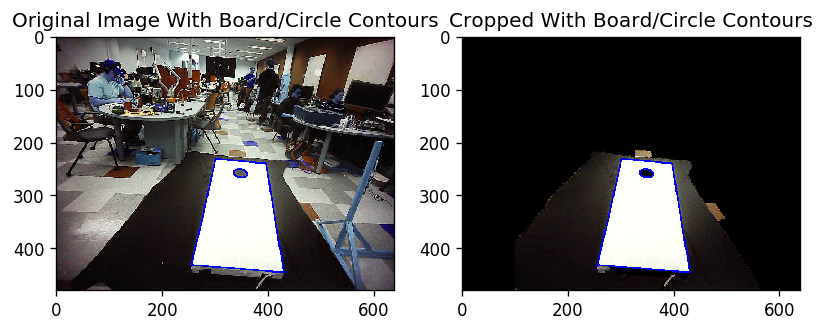

In [3]:
# Do algorithm grabCut(...) to separate foreground from background
mask = np.zeros(img.shape[:2], np.uint8)

bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

#rect = (100,100, 450,500) # y1x1,y2x2
rect = (100,200,height,width)
cv.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

# threshold binarily
#ret,thresh = cv.threshold(img,127,255,cv.THRESH_BINARY)

# find contours
graysrc = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)

# Get board contour and potential hole contours
board_cnt = None
hole_cnt = None
for cnt in contours:
        
    print_cnt_details(cnt)
    if (cnt_is_circular(cnt)):
        hole_cnt = cnt
    if (cnt_is_board(cnt)):
        board_cnt = cnt

orig_w_cnts = cv.drawContours(orig.copy(), contours, -1, (0,0,255), 2)
crop_w_cnts = cv.drawContours(img.copy(), contours, -1, (0,0,255), 2)

# Plot original image with ALL contours
fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(1,2,1)
plt.imshow(orig_w_cnts)
a.set_title('Original Image With All Contours')
a = fig.add_subplot(1,2,2)
plt.imshow(crop_w_cnts)
a.set_title('Cropped With All Contours')

# Show ONLY supposed board and circle contours
cnts = [x for x in [hole_cnt, board_cnt] if x is not None]
orig_w_cnts = cv.drawContours(orig.copy(), cnts, -1, (0,0,255), 2)
crop_w_cnts = cv.drawContours(img.copy(), cnts, -1, (0,0,255), 2)

fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(1,2,1)
plt.imshow(orig_w_cnts)
a.set_title('Original Image With Board/Circle Contours')
a = fig.add_subplot(1,2,2)
plt.imshow(crop_w_cnts)
a.set_title('Cropped With Board/Circle Contours')


cx:  345 	cy:  347 	area:  27398.5 	perimeter:  727.3208485841751 	vertices:  4
cx:  347 	cy:  258 	area:  312.5 	perimeter:  69.35533845424652 	vertices:  12


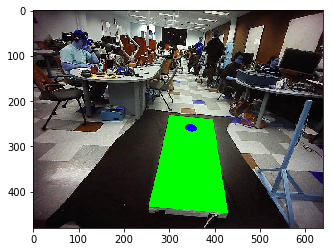

In [4]:

if (board_cnt is not None and hole_cnt is not None):
    cv.drawContours(orig, [board_cnt], 0, (0,255,0), cv.FILLED)
    print_cnt_details(board_cnt)
    cv.drawContours(orig, [hole_cnt], 0, (0,0,255), cv.FILLED)
    print_cnt_details(hole_cnt)
    plt.imshow(orig)
else:
    print("board_cnt or hole_cnt null")
    print("board contour: "), print_cnt_details(board_cnt)
    print("hole contour: "), print_cnt_details(hole_cnt)

In [ ]:
black = np.zeros((img.shape[0], img.shape[1], 3), np.uint8) #---black in RGB
black1 = cv2.rectangle(black,(185,13),(407,224),(255, 255, 255), -1)   #---the dimension of the ROI
gray = cv2.cvtColor(black,cv2.COLOR_BGR2GRAY)               #---converting to gray
ret,b_mask = cv2.threshold(gray,127,255, 0)                 #---converting to binary image
